# BAPTAT - first version

0. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, autograd
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import math


from Data_Compiler.amc_parser import test_all, parse_amc


## 1. Define Classes

In [2]:
class Preprocessor():
    def __init__(self, num_features, num_dimensions):
        self._num_features = num_features
        self._num_dimensions = num_dimensions


    def compile_data(self, asf_path, amc_path, frame_samples):
        visual_input, selected_joint_names = test_all(asf_path, amc_path, frame_samples, 30) 
        visual_input = torch.from_numpy(visual_input).type(torch.float)

        return visual_input, selected_joint_names
    

    def create_inout_sequences(self, input_data, tw):
        inout_seq = []
        L = len(input_data)
        for i in range(L-tw):
            train_seq = input_data[i:i+tw]
            train_label = input_data[i+tw:i+tw+1]
            inout_seq.append((train_seq ,train_label))
        return inout_seq


    def get_LSTM_data(self, asf_path, amc_path, frame_samples, num_test_data, train_window):
        visual_input, selected_joint_names = self.compile_data(asf_path=asf_path, amc_path=amc_path, frame_samples=frame_samples)

        visual_input = visual_input.permute(1,0,2)
        visual_input = visual_input.reshape(1, frame_samples, self._num_dimensions*self._num_features)

        train_data = visual_input[:,:-num_test_data,:]
        test_data = visual_input[:,-num_test_data:,:]

        train_inout_seq = self.create_inout_sequences(train_data[0], train_window)

        # train_data = train_data.reshape(frame_samples-num_test_data, self._num_features, self._num_dimensions)

        return train_inout_seq, train_data, test_data

    
    def get_AT_data(self, asf_path, amc_path, frame_samples):
        visual_input, selected_joint_names = self.compile_data(asf_path=asf_path, amc_path=amc_path, frame_samples=frame_samples)
        visual_input = visual_input.permute(1,0,2)

        return visual_input, selected_joint_names
    

    def convert_data_AT_to_LSTM(self, data):
        return data.reshape(1, self._num_dimensions*self._num_features)
        # return data.reshape(1, num_samples, self._num_dimensions*self._num_features)


    def convert_data_LSTM_to_AT(self, data): 
        return data.reshape(self._num_features, self._num_dimensions)
        # return data.reshape(num_samples, self._num_features, self._num_dimensions)


In [3]:
class CORE_NET(nn.Module):
    def __init__(self, input_size=45, hidden_layer_size=90, num_layers=1, output_size=45):
        super(CORE_NET,self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_layer_size, out_features=output_size)

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [4]:
class LSTM_Trainer():
    ## General parameters 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def __init__(self, loss_function=nn.MSELoss(), learning_rate=0.0001):
        self._model = CORE_NET()
        self._loss_function = loss_function
        self._optimizer = torch.optim.Adam(self._model.parameters(), lr=learning_rate)

        print('Initialized model!')
        print(self._model)
        print(self._loss_function)
        print(self._optimizer)


    def train(self, epochs, train_sequence, save_path):
        losses = []

        for i in range(epochs):
            for seq, labels in train_sequence:
                self._optimizer.zero_grad()

                y_pred = self._model(seq)

                single_loss = self._loss_function(y_pred, labels)
                single_loss.backward()
                self._optimizer.step()

            # save loss of epoch
            losses.append(single_loss.item())
            if i%25 == 1:
                print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        
        print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
        
        self.save_model(save_path)
        self.plot_losses(losses)

        return losses
    

    def plot_losses(self, losses):
        fig = plt.figure()
        axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 
        axes.plot(losses, 'r')
        axes.grid(True)
        axes.set_xlabel('epochs')
        axes.set_ylabel('prediction error')
        axes.set_title('History of MSELoss during training')
        plt.show()


    def save_model(self, path):
        torch.save(self._model.state_dict(), path)
        print('Model was saved in: ' + path)


In [5]:
class LSTM_Tester(): 

    def __init__(self, loss_function=nn.MSELoss()):
        self._loss_function = loss_function


    def predict(self, num_predictions, model, test_input, test_target, train_window): 
        prediction_error = []

        for i in range(num_predictions):
            seq = test_input[-train_window:]

            with torch.no_grad():
                if i>0:
                    loss = self._loss_function(test_input[-1], test_target[0,i]).item()
                    prediction_error.append(loss)

                new_prediction = model(seq)
                test_input = torch.cat((test_input, new_prediction.reshape(1,45)), 0)

        predictions = test_input[-num_predictions:].reshape(num_predictions, 15, 3)

        return predictions, prediction_error

    
    def plot_pred_error(self, errors):
        fig = plt.figure()
        axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 
        axes.plot(errors, 'r')
        axes.grid(True)
        axes.set_xlabel('time steps')
        axes.set_ylabel('prediction error')
        axes.set_title('Prediction error during testing')
        plt.show()

    
    def test(self, num_predictions, model_path, test_input, test_target, train_window):
        model = CORE_NET()
        model.load_state_dict(torch.load(model_path))
        model.eval()
        print(model)

        pred, pred_err = self.predict(num_predictions, model, test_input, test_target, train_window)

        self.plot_pred_error(pred_err)


In [6]:
class Perspective_Taker():

    """
    Performs Perspective Taking 
    """

    def __init__(self, alpha_init, beta_init, gamma_init, 
                rotation_gradient_init, translation_gradient_init):

        self.rotation_gradient_init = rotation_gradient_init
        self.translation_gradient_init = translation_gradient_init
        
        self.dimensions = 3
        
        ## Translation
        # initialize translation bias
        self.translation_bias = torch.rand(self.dimensions, requires_grad=self.translation_gradient_init)           

        ## Rotation
        # initialize rotation angles 
        self.alpha = Variable(torch.tensor(alpha_init), requires_grad=False)
        self.beta = Variable(torch.tensor(beta_init), requires_grad=False)
        self.gamma = Variable(torch.tensor(gamma_init), requires_grad=False)

        # initialize dimensional rotation matrices 
        self.R_x = Variable(torch.tensor([[1.0,0.0,0.0],
                                [0.0, torch.cos(self.alpha), - torch.sin(self.alpha)], 
                                [0.0, torch.sin(self.alpha), torch.cos(self.alpha)]]), 
                                requires_grad=False) 
        self.R_y = Variable(torch.tensor([[torch.cos(self.beta), 0.0, torch.sin(self.beta)], 
                                [0.0,1.0,0.0],
                                [- torch.sin(self.beta), 0.0, torch.cos(self.beta)]]), 
                                requires_grad=False) 
        self.R_z = Variable(torch.tensor([[torch.cos(self.gamma), - torch.sin(self.gamma), 0.0], 
                                [torch.sin(self.gamma), torch.cos(self.gamma), 0.0], 
                                [0.0,0.0,1.0]]), 
                                requires_grad=False)

        # initialize rotation matrix
        self.rotation_matrix = Variable(torch.matmul(self.R_z, torch.matmul(self.R_y, self.R_x)),
                                        requires_grad=self.rotation_gradient_init)

        # ALTERNATIVE: calculating gradients with respect to alphas -> update alphas -> neg: invers matmul                          
        # # initialize rotation angles 
        # self.alpha = Variable(torch.tensor(alpha_init), requires_grad=self.rotation_gradient_init)
        # self.beta = Variable(torch.tensor(beta_init), requires_grad=self.rotation_gradient_init)
        # self.gamma = Variable(torch.tensor(gamma_init), requires_grad=self.rotation_gradient_init)

        # # initialize dimensional rotation matrices 
        # self.R_x = Variable(torch.tensor([[1.0,0.0,0.0],
        #                         [0.0, torch.cos(self.alpha), - torch.sin(self.alpha)], 
        #                         [0.0, torch.sin(self.alpha), torch.cos(self.alpha)]]), 
        #                         requires_grad=self.rotation_gradient_init) 
        # self.R_y = Variable(torch.tensor([[torch.cos(self.beta), 0.0, torch.sin(self.beta)], 
        #                         [0.0,1.0,0.0],
        #                         [- torch.sin(self.beta), 0.0, torch.cos(self.beta)]]), 
        #                         requires_grad=self.rotation_gradient_init) 
        # self.R_z = Variable(torch.tensor([[torch.cos(self.gamma), - torch.sin(self.gamma), 0.0], 
        #                         [torch.sin(self.gamma), torch.cos(self.gamma), 0.0], 
        #                         [0.0,0.0,1.0]]), 
        #                         requires_grad=self.rotation_gradient_init)

        # # initialize rotation matrix
        # self.rotation_matrix = Variable(torch.matmul(self.R_z, torch.matmul(self.R_y, self.R_x)),
        #                                 requires_grad=self.rotation_gradient_init)


    def translation_bias_(self):
        return self.translation_bias


    def update_translation_bias_(self, gradient, learning_rate):
        self.translation_bias = Variable(self.translation_bias - learning_rate * gradient,
                                        requires_grad=self.translation_gradient_init)
        # print('Updated translation bias.')
        # print(self.translation_bias)
        return self.translation_bias


    def update_rotation_matrix_(self, gradient, learning_rate):
        self.rotation_matrix = Variable(self.rotation_matrix - learning_rate * gradient,
                                        requires_grad=self.rotation_gradient_init)
        # print('Updated rotation matrix.')
        # print(self.rotation_matrix)
        return self.rotation_matrix


    def rotation_matrix_(self):
        return self.rotation_matrix


    def rotate(self, input):
        return torch.matmul(self.rotation_matrix, input.T).T


    def rotate(self, input, rotation_matrix):
        return torch.matmul(rotation_matrix, input.T).T


    def translate(self,input): 
        return input + self.translation_bias


    def translate(self,input, translation_bias): 
        return input + translation_bias


In [7]:
class Binder():
    """
    Performs Binding task. 
    """

    def __init__(self, num_features, gradient_init):
        self.gradient_init = gradient_init
        self.binding_matrix = torch.nn.init.uniform_(
                                torch.empty(num_features, num_features, 
                                            requires_grad=self.gradient_init))
    

    def binding_matrix_(self):
        return self.binding_matrix


    def update_binding_matrix_(self, gradient, learning_rate):
        self.binding_matrix = Variable(self.binding_matrix - learning_rate * gradient, 
                                        requires_grad=self.gradient_init)
        # print('Updated binding matrix.')
        # print(self.binding_matrix)
        return self.binding_matrix


    def bind(self, input):
        return torch.matmul(self.binding_matrix, input)


    def bind(self, input, binding_matrix):
        return torch.matmul(binding_matrix, input)


## 2. LSTM Part

Initialized model!
CORE_NET(
  (lstm): LSTM(45, 90, batch_first=True)
  (linear): Linear(in_features=90, out_features=45, bias=True)
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
parsing Data_Compiler/S35T07.asf
Parsing is Done!
(30, 1000, 3)
X is between  -4.061964406154871 and 5.9986193210825896
Y is between -17.74003022387414 and 11.429187509515206
Z is between -6.189523090354323 and 9.517420344669963
epoch:   1 loss: 2.88219357
epoch:  26 loss: 0.01384499
epoch:  51 loss: 0.00413799
epoch:  76 loss: 0.01264670
epoch:  99 loss: 0.0081328917
Model was saved in: CoreLSTM/models/LSTM_2.pt


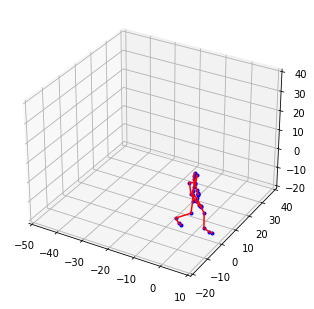

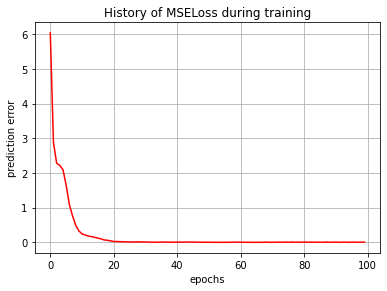

In [319]:
# LSTM parameters
frame_samples = 1000
train_window = 10
testing_size = 100

# Init tools
prepro = Preprocessor(15, 3)
trainer = LSTM_Trainer()
tester = LSTM_Tester()

# Define paths for data and LSTM
data_asf_path = 'Data_Compiler/S35T07.asf'
data_amc_path = 'Data_Compiler/S35T07.amc'
model_save_path = 'CoreLSTM/models/LSTM_2.pt'

# Preprocess data
io_seq, dt_train, dt_test = prepro.get_LSTM_data(data_asf_path, data_amc_path, 
                                                    frame_samples, testing_size, train_window)

# Train LSTM
losses = trainer.train(100, io_seq, model_save_path)


CORE_NET(
  (lstm): LSTM(45, 90, batch_first=True)
  (linear): Linear(in_features=90, out_features=45, bias=True)
)


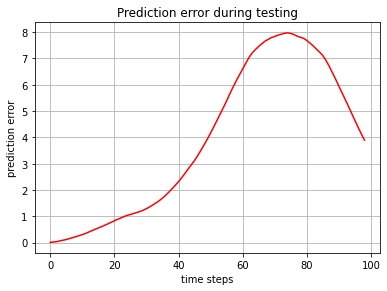

In [10]:
# Get testing data and tester
test_input =  dt_train[0,-train_window:]
tester = LSTM_Tester()

# Test LSTM
tester.test(testing_size, model_save_path, test_input, dt_test, train_window)

## 3. Active Tuning Part 

parsing Data_Compiler/S35T07.asf
Parsing is Done!
(30, 50, 3)
X is between  -3.851871038822753 and 5.348447334315501
Y is between -17.74003022387414 and 11.410987704038925
Z is between -6.026005243797416 and 8.388741927126086
initial translation bias:
 tensor([3., 3., 3.])
initial rotation matrix:
 tensor([[ 0.9900, -0.0894,  0.1088],
        [ 0.0993,  0.9910, -0.0894],
        [-0.0998,  0.0993,  0.9900]])
----------------------------------------------
tensor(False)
frame: 11 cycle: 0 loss: 665.34033203125
preds: 0
----------------------------------------------
tensor(False)
frame: 12 cycle: 0 loss: 75.34026336669922
preds: 0
----------------------------------------------
tensor(False)
frame: 13 cycle: 0 loss: 50.19646453857422
preds: 0
----------------------------------------------
tensor(False)
frame: 14 cycle: 0 loss: 49.59869384765625
preds: 0
----------------------------------------------
tensor(False)
frame: 15 cycle: 0 loss: 49.496917724609375
preds: 0
------------------------

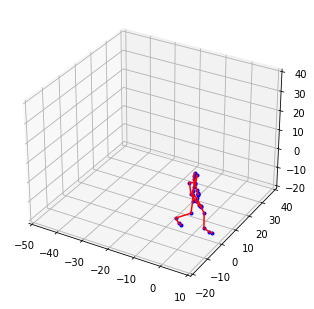

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autograd.set_detect_anomaly(True)

## Define tuning parameters 
tuning_length = 10      # length of tuning horizon 
tuning_cycles = 1       # number of tuning cycles in each iteration 
at_loss_function = nn.MSELoss()

at_final_predictions = torch.tensor([])
B_grads = [None] * tuning_length
C_grads = [None] * tuning_length
R_grads = [None] * tuning_length

at_learning_rate = 0.001


## Define data parameters
data_at_unlike_train = True
num_frames = 50
# 50 -> always working, no NaNs
# 56/57 -> sometimes working, sometimes NaNs
# >57 -> always NaNs
num_input_features = 15
num_input_dimensions = 3
preprocessor = Preprocessor(num_input_features, num_input_dimensions)

# data paths 
data_asf_path = 'Data_Compiler/S35T07.asf'
data_amc_path = 'Data_Compiler/S35T07.amc'

####################### Note: sample needs to be changed in the future

## Define model parameters 
model_path = 'CoreLSTM/models/LSTM_2.pt'

## Define Binding and Perspektive Taking parameters 
# Binding
binder = Binder(num_features=num_input_features, gradient_init=True)

# Perspective Taking
perspective_taker = Perspective_Taker(alpha_init=0.0, beta_init=0.0, gamma_init=0.0, 
                    rotation_gradient_init=True, translation_gradient_init=True)


## Create list of parameters for gradient descent
Bs = []
Cs = []
Rs = []
################################################### appending separate matrices or only references?
###################### maybe tensors not lists? -> backprop possible 
for i in range(tuning_length):
    Bs.append(binder.binding_matrix_())
    Cs.append(perspective_taker.translation_bias_())
    Rs.append(perspective_taker.rotation_matrix_())

# print(Bs[0])
# print(Cs[0])
# print(Rs[0])

## Load data
observations, feature_names = preprocessor.get_AT_data(data_asf_path, data_amc_path, num_frames)

## Change data according to given parameters
if (data_at_unlike_train):
    ## translate data 
    init_translation_bias = torch.Tensor([3.0, 3.0, 3.0])
    print(f'initial translation bias:\n {init_translation_bias}')
    for i in range(num_frames):
        observations[i] = perspective_taker.translate(observations[i], init_translation_bias)

    ## rotate data 
    # rotation angles 
    init_alpha = Variable(torch.tensor(0.1))
    init_beta = Variable(torch.tensor(0.1))
    init_gamma = Variable(torch.tensor(0.1))

    # dimensional rotation matrices 
    init_R_x = Variable(torch.tensor([[1.0,0.0,0.0],
                            [0.0, torch.cos(init_alpha), - torch.sin(init_alpha)], 
                            [0.0, torch.sin(init_alpha), torch.cos(init_alpha)]])) 
    init_R_y = Variable(torch.tensor([[torch.cos(init_beta), 0.0, torch.sin(init_beta)], 
                            [0.0,1.0,0.0],
                            [- torch.sin(init_beta), 0.0, torch.cos(init_beta)]])) 
    init_R_z = Variable(torch.tensor([[torch.cos(init_gamma), - torch.sin(init_gamma), 0.0], 
                            [torch.sin(init_gamma), torch.cos(init_gamma), 0.0], 
                            [0.0,0.0,1.0]]))

    # rotation matrix
    init_rotation_matrix = Variable(torch.matmul(init_R_z, torch.matmul(init_R_y, init_R_x)))
    print(f'initial rotation matrix:\n {init_rotation_matrix}')
    for i in range(num_frames):
        observations[i] = perspective_taker.rotate(observations[i], init_rotation_matrix)

    ## rebind data
    # TODO
    
## Load model
core_model = CORE_NET()
core_model.load_state_dict(torch.load(model_path))
core_model.eval()

#### FORWARD PASS FOR ONE TUNING HORIZON --- NOT closed loop! preds based on observations
obs_count = 0
at_inputs = torch.tensor([])
at_predictions = torch.tensor([])

for i in range(tuning_length):
    o = observations[obs_count]
    obs_count += 1

    x_B = binder.bind(o, Bs[i])
    x_C = perspective_taker.translate(x_B, Cs[i])
    x_R = perspective_taker.rotate(x_C, Rs[i])

    x = preprocessor.convert_data_AT_to_LSTM(x_R)

    at_inputs = torch.cat((at_inputs, x), 0)
    
    with torch.no_grad():
        new_prediction = core_model(x)
        at_predictions = torch.cat((at_predictions, new_prediction.reshape(1,45)), 0)


#### ACTIVE TUNING PART 

while obs_count < num_frames:
    # TODO folgendes evtl in function auslagern
    o = observations[obs_count]
    obs_count += 1

    x_B = binder.bind(o, Bs[-1])
    x_C = perspective_taker.translate(x_B, Cs[-1])
    x_R = perspective_taker.rotate(x_C, Rs[-1])

    x = preprocessor.convert_data_AT_to_LSTM(x_R)

    ## Generate current prediction 
    with torch.no_grad():
        new_prediction = core_model(x)

    ## For #tuning_cycles 
    for cycle in range(tuning_cycles):
        print('----------------------------------------------')

        # get prediction
        p = at_predictions[-1]
        print(torch.isnan(p).any())

        # calculate error 
        loss = at_loss_function(p, x)
        print(f'frame: {obs_count} cycle: {cycle} loss: {loss}')

        # propagate error back through tuning horizon 
        loss.backward(retain_graph=True)
        ############################# retain_graph = True ? 
        ############################# optimizer? Adam.. 

        # for i in TH
        for i in range(tuning_length):
            # save grads for all parameters in all time steps of tuning horizon 
            B_grads[i] = Bs[i].grad
            C_grads[i] = Cs[i].grad
            R_grads[i] = Rs[i].grad
            # Working? not all tensors.. maybe add Varables? --> added Variables  
        
        # calculate overall gradients 
        grad_B = torch.mean(torch.stack(B_grads))
        grad_C = torch.mean(torch.stack(C_grads))
        grad_R = torch.mean(torch.stack(R_grads))

        # update parameters in time step t-H with saved gradients 
        upd_B = binder.update_binding_matrix_(grad_B, at_learning_rate)
        upd_C = perspective_taker.update_translation_bias_(grad_C, at_learning_rate)
        upd_R = perspective_taker.update_rotation_matrix_(grad_R, at_learning_rate)

        # zero out gradients for all parameters in all time steps of tuning horizon
        for i in range(tuning_length):
            Bs[i].grad.data.zero_()
            Cs[i].grad.data.zero_()
            Rs[i].grad.data.zero_()
        
        with torch.no_grad(): ######## torch.no_grad applying here or later??
            # update all parameters for all time steps 
            for i in range(tuning_length):
                Bs[i] = upd_B
                Cs[i] = upd_C
                Rs[i] = upd_R

            # print(Bs[0])
            # print(Cs[0])
            # print(Rs[0])

            # forward pass from t-H to t with new parameters 
            for i in range(tuning_length):
                o = preprocessor.convert_data_LSTM_to_AT(at_inputs[i])
                x_B = binder.bind(o, Bs[i])
                x_C = perspective_taker.translate(x_B, Cs[i])
                x_R = perspective_taker.rotate(x_C, Rs[i])

                x = preprocessor.convert_data_AT_to_LSTM(x_R)

                at_predictions[i] = core_model(x)   # working? right shape? 
                # with torch.no_grad():  
                    # at_predictions[i] = core_model(x)   # funktioniert das? right shape? 
            print(f'preds: {torch.isnan(at_predictions).sum()}')
            ## --> currently: only last prediction gives NaNs
            
    # reorganize storage
    at_inputs = torch.cat((at_inputs[1:], x.reshape(1,45)), 0)
    at_final_predictions = torch.cat((at_final_predictions, at_predictions[0].reshape(1,45)), 0)

    # generate updated prediction 
    with torch.no_grad():
        new_prediction = core_model(x)
    at_predictions = torch.cat((at_predictions[1:], new_prediction.reshape(1,45)), 0)
    
# store rest of predictions in at_final_predictions
for i in range(tuning_length): 
    at_final_predictions = torch.cat((at_final_predictions, at_predictions[1].reshape(1,45)), 0)


print(Bs[0])
print(Cs[0])
print(Rs[0])

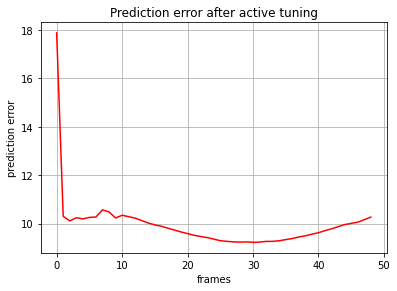

In [29]:
#### EVALUATION / VISUALIZATION OF RESULTS 
at_prediction_err = []
for i in range(num_frames-1):
    with torch.no_grad():
        obs_t = preprocessor.convert_data_AT_to_LSTM(observations[i+1])
        pred_t = at_final_predictions[i]
        loss = at_loss_function(pred_t, obs_t)
        at_prediction_err.append(loss)

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 
axes.plot(at_prediction_err, 'r')
axes.grid(True)
axes.set_xlabel('frames')
axes.set_ylabel('prediction error')
axes.set_title('Prediction error after active tuning')
plt.show()

In [30]:
at_final_pred_plot = at_final_predictions.reshape(num_frames, 15, 3)

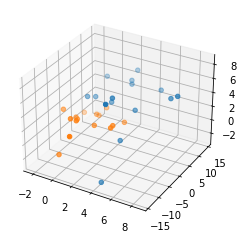

In [31]:
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.scatter3D(observations[0,:,0], observations[0,:,1], observations[0,:,2])
ax.scatter3D(at_final_pred_plot[0,:,0], at_final_pred_plot[0,:,1], at_final_pred_plot[0,:,2])
plt.show()

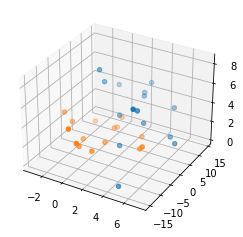

In [32]:
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.scatter3D(observations[num_frames-1,:,0], observations[num_frames-1,:,1], observations[num_frames-1,:,2])
ax.scatter3D(at_final_pred_plot[num_frames-1,:,0], at_final_pred_plot[num_frames-1,:,1], at_final_pred_plot[num_frames-1,:,2])
plt.show()